### Simulation Study
\usepackage{eqnarray,amsmath}

Suppose we want to forecast a full season ahead using an SIR model, this simulation study demonstrates how we could do that using a new technique, robust to noise.


Suppose we have a time series 

$$Y_1,Y_2,....,Y_T$$ where 
$$T= k*S$$

that is, we have $k$ seasons of data.


We can write $$\{Y_1,...Y_S\} = S_1$$



For each $S_i$ we can fit a simple sir model of the form 

$$\begin{align}
&\frac{dS}{dt} = -\beta_i S\cdot I \\
&\frac{dI}{dt} = \beta_i S\cdot I - \gamma_i  I \\
&\frac{dR}{dt} = \gamma I 
\end{align}$$

In order to forecast a full season ahead we can use an state-space model on the $\beta_i, \gamma_i$ 


$$\begin{align}
& \beta_i \sim N(X_i,\sigma_{\beta}^2)\\
& X_i \sim N(X_{i-1},\sigma_{X}^2)\\
& \gamma_i \sim N(Y_i,\sigma_{\gamma}^2)\\
& Y_i \sim N(Y_{i-1},\sigma_{Y}^2)
\end{align}$$


this relates SIR curves of one season to another, and we can generate forecasts of a full season ahead. 



This simulation study generates data from this model and uses CV to evalaute it. The generated data looks very much like real data!

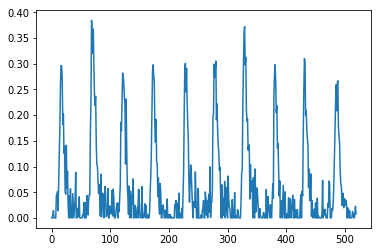

In [12]:
import scipy.integrate as spi
import numpy as np
import pylab as pl
from scipy.stats import truncnorm
import scipy.integrate as spi
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt

def simple_sir(x,beta,gamma):
    #beta=1.4247
    #gamma=0.14286
    TS=1
    ND=51
    S0=1-1e-6
    I0=1e-6
    INPUT = (S0, I0, 0.0)


    def diff_eqs(INP,t):  
        '''The main set of equations'''
        Y=np.zeros((3))
        V = INP    
        Y[0] = - beta * V[0] * V[1]
        Y[1] = beta * V[0] * V[1] - gamma * V[1]
        Y[2] = gamma * V[1]
        return Y   # For odeint

    t_start = 0.0; t_end = ND; t_inc = TS
    t_range = np.arange(t_start, t_end+t_inc, t_inc)
    RES = spi.odeint(diff_eqs,INPUT,t_range)
    return RES[:,1][:len(x)]

def generate_data(x,beta,gamma):

    TS=1.0
    ND=70
    S0=1-1e-6
    I0=1e-6
    INPUT = (S0, I0, 0.0)


    def diff_eqs(INP,t):  
        '''The main set of equations'''
        Y=np.zeros((3))
        V = INP    
        Y[0] = - beta * V[0] * V[1]
        Y[1] = beta * V[0] * V[1] - gamma * V[1]
        Y[2] = gamma * V[1]
        return Y   # For odeint

    t_start = 0.0; t_end = ND; t_inc = TS
    t_range = np.arange(t_start, t_end+t_inc, t_inc)
    RES = spi.odeint(diff_eqs,INPUT,t_range)
    return RES[:,1] +  truncnorm.rvs(0, 100000, scale=.001, size=71)

count =0
data = []
SIMULATE = True
if not SIMULATE:
    with open ("/Users/gcgibson/Downloads/San_Juan_Training_Data.csv") as f:
            for line in f.readlines():
                if count > 0:
                    data.append(line.replace("\n","").split(',')[-1])
                count +=1
else:
    for i in range(10):
        tmp = simple_sir(range(52),1.1+np.random.normal(0,.075),.2+np.random.normal(0,.075))
        data.append(tmp.tolist())

#print (data)
   
data = np.array(data,dtype=np.float32).flatten()
data += np.random.normal(0,.05,size=len(data))
data = data/np.max(data+1)
data =  np.clip(data, 0, 1)
generated_data = data[:52]
plt.plot(data)
plt.show()

/Users/gcgibson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in double_scalars
/Users/gcgibson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in double_scalars
/Users/gcgibson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in double_scalars
/Users/gcgibson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars


[1.3374455  0.43374265]


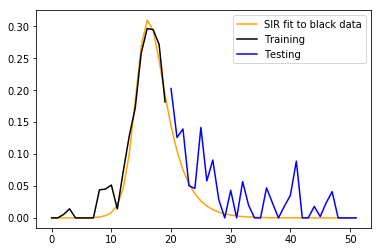

In [13]:
from scipy.optimize import curve_fit




def fit_sir_to_data(data):
    popt, pcov = curve_fit(simple_sir, range(len(data)), data)
    local_sampled_trajectories = simple_sir(range(52),popt[0],popt[1])
    return local_sampled_trajectories,popt
sample,popt = fit_sir_to_data(data[:20])
print (popt)
plt.plot(range(52),sample,color="orange")
plt.plot(range(20),data[:20],color="black")
plt.plot(range(20,52),data[20:52],color="blue")
plt.legend(("SIR fit to black data","Training","Testing"))
plt.show()

/Users/gcgibson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in double_scalars
/Users/gcgibson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in double_scalars
/Users/gcgibson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
/Users/gcgibson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in double_scalars


Starting forward filtering...
Forward fitering completed.
Starting forward filtering...
Forward fitering completed.
(1.1639581847703353, 0.35028909702142014)


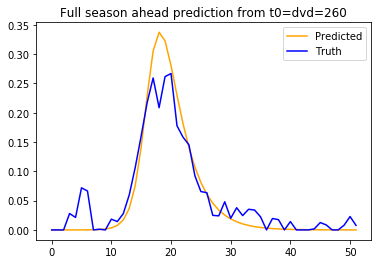

In [18]:

seasons = []
start = 5
for i in range(0,52*start,52):
    seasons.append(data[i:(i+52)])
#def predict_sir():
betas = []
gammas = []

for season in seasons:
    _,popt = fit_sir_to_data(season)
    betas.append(popt[0])
    gammas.append(popt[1])

from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason
myDLM = dlm(betas)
#myDLM = myDLM + trend(1, name='lineTrend', w=1.0)
myDLM = myDLM +autoReg(degree=1,data=betas, discount=0.99, name='ar3', w=1e7)

myDLM.fitForwardFilter()
beta_pred = myDLM.predictN(N=1)[0][0]


myDLM = dlm(gammas)
#myDLM = myDLM + trend(1, name='lineTrend', w=1.0)
myDLM = myDLM +autoReg(degree=1,data=betas ,discount=0.99, name='ar3', w=1e7)

myDLM.fitForwardFilter()
gamma_pred = myDLM.predictN(N=1)[0][0]


#plt.plot(betas)
#plt.plot(gammas)
#plt.show()

print (beta_pred,gamma_pred)
plt.plot(simple_sir(range(52),beta_pred,gamma_pred),color="orange")
plt.plot(data[52*9:52*10],color="blue")
plt.legend(("Predicted","Truth"))
plt.title("Full season ahead prediction from t0=dvd="+str(start*52))
plt.show()